In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

In [3]:
from core.SimpleNet import SimpleNet
from core.GraphConvNet import GraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from core.GraphDataBlock import GraphDataBlock
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import evaluate_viz_metrics, trustworthiness, neighborhood_preservation
from util.network_utils import get_net_projection, _get_net_projection
from util.graph_utils import get_shortest_path_matrix, neighbor_sampling

cuda not available
cuda not available


In [4]:
if torch.cuda.is_available():
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    print('cuda available')
    device = 'cuda'
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    print('cuda not available')
    device = 'cpu'

cuda not available


In [5]:
dataset_name = 'reddit_test'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)
dataset.summarise()

Data blocks of length:  [55334]
Time to create all data (s) = 0.3785
Name of dataset = reddit_test
Input dimension = 602
Number of training samples = 55334
Training labels = True


In [6]:
net_dir = 'reddit_full'
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['L'] = 2 # number of hidden layers

In [7]:
# path_matrix = get_shortest_path_matrix(dataset.adj_matrix.toarray())
# print(path_matrix.shape)
# np.save('path_matrix.npy', path_matrix)

## End of boilerplate code

In [8]:
main_dir = os.path.join('results', net_dir)
main_dir

'results/reddit_full'

In [9]:
# Graph net
def load_net_from_root(root, net_parameters, epoch):
    net_parameters['H'] = 256 # number of hidden units
    net_1 = GraphConvNet(net_parameters)
    if torch.cuda.is_available(): net_1.cuda()
    filename = os.path.join(root, 'graph_net_{}.pkl'.format(epoch))
    checkpoint = torch.load(filename, map_location=device)
    net_1.load_state_dict(checkpoint['state_dict'])
    return net_1

In [10]:
def project_and_eval(net, graph_block, path_matrix):
    y_pred = _get_net_projection(net, graph_block)
    res = evaluate_viz_metrics(y_pred, graph_block, verbose=0)
    res['Feature trustworthiness'] = trustworthiness(graph_block.inputs, y_pred, metric='cosine', n_neighbors=12)
    res['Graph trustworthiness'] = neighborhood_preservation(y_pred, path_matrix)
    return res

In [11]:
from collections import defaultdict

res_summary = defaultdict(lambda: [0]*11)
n_samples = 50
for iter in range(n_samples):
    sampled_block = dataset.get_sample_block(n_initial=50, sample_neighbors=True, verbose=1)
    path_matrix = get_shortest_path_matrix(sampled_block.adj_matrix)
    
    for i in range(1, 12):
        root = os.path.join(main_dir, net_dir) + '_' + str(i)
        net = load_net_from_root(root, net_parameters, epoch=4)
        res = project_and_eval(net, sampled_block, path_matrix)
        for k, v in res.items():
            res_summary[k][i-1] += v

for k, v in res_summary.items():
    res_summary[k] = np.array(v) / n_samples

Initial set of 50 points was expanded to 4490 points
Initial set of 50 points was expanded to 4972 points
Initial set of 50 points was expanded to 4459 points
Initial set of 50 points was expanded to 4617 points
Initial set of 50 points was expanded to 4676 points
Initial set of 50 points was expanded to 4466 points
Initial set of 50 points was expanded to 4627 points
Initial set of 50 points was expanded to 4739 points
Initial set of 50 points was expanded to 4615 points
Initial set of 50 points was expanded to 4853 points
Initial set of 50 points was expanded to 4443 points
Initial set of 50 points was expanded to 4392 points
Initial set of 50 points was expanded to 4531 points
Initial set of 50 points was expanded to 4572 points
Initial set of 50 points was expanded to 4577 points
Initial set of 50 points was expanded to 4583 points
Initial set of 50 points was expanded to 4668 points
Initial set of 50 points was expanded to 4613 points
Initial set of 50 points was expanded to 4413 

In [12]:
test_range = np.linspace(0, 1, num=11)

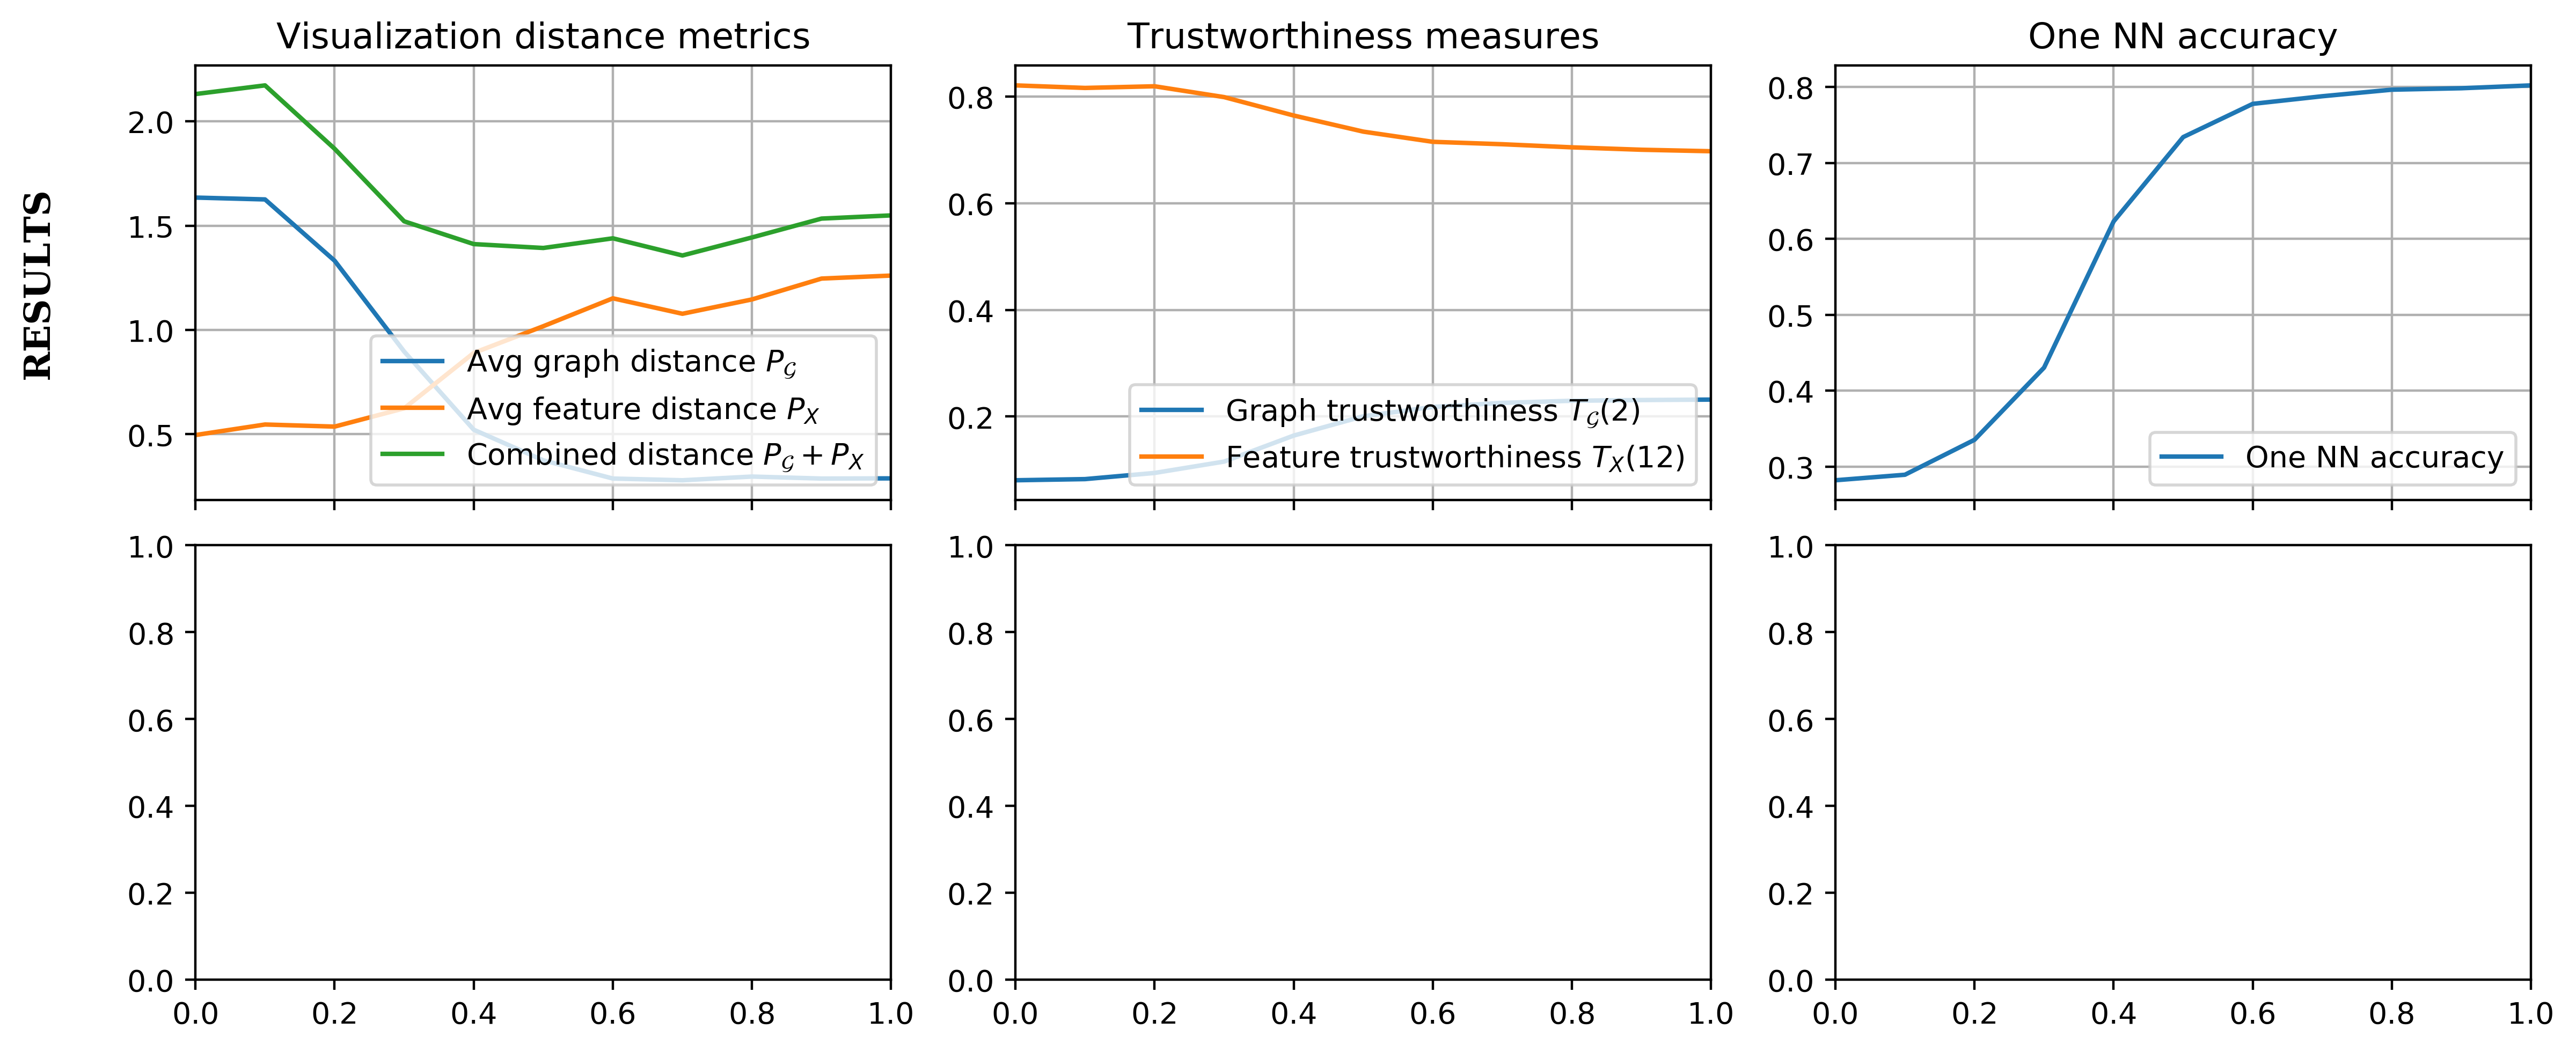

In [13]:
n_rows = 2
labels = ['RESULTS']
summary = [res_summary]

f, axarr = plt.subplots(n_rows, 3, sharex=True, figsize=(12, 5), dpi=400)
for i in range(len(summary)):
    axarr[i,0].plot(test_range, summary[i]['Avg graph distance'], label=r'Avg graph distance $P_{\mathcal{G}}$')
    axarr[i,0].plot(test_range, summary[i]['Avg feature distance'], label=r'Avg feature distance $P_{X}$')
    axarr[i,0].plot(test_range, summary[i]['Total distance'], label='Combined distance $P_{\mathcal{G}} + P_{X}$')
    if i == 0:
        axarr[i,0].set_title('Visualization distance metrics')
    elif i == n_rows-1:
        axarr[i,0].set_xlabel('alpha')
    axarr[i,0].set_xlim(0,1)
    axarr[i,0].set_ylabel(labels[i], fontdict={'fontsize': 12, 'fontweight': 'bold', 'fontname': 'serif'})
    axarr[i,0].yaxis.set_label_coords(-0.2,0.5)
    axarr[i,0].grid()
    axarr[i,0].legend(loc='lower right')

    axarr[i,1].plot(test_range, summary[i]['Graph trustworthiness'], label=r'Graph trustworthiness $T_{\mathcal{G}}(2)$')
    axarr[i,1].plot(test_range, summary[i]['Feature trustworthiness'], label=r'Feature trustworthiness $T_{X}(12)$')
    if i==0:
        axarr[i,1].set_title('Trustworthiness measures')
    elif i == n_rows-1:
        axarr[i,1].set_xlabel('alpha')
    axarr[i,1].set_xlim(0,1)
    axarr[i,1].grid()
    axarr[i,1].legend(loc='lower right')

    axarr[i,2].plot(test_range, summary[i]['One NN accuracy'], label='One NN accuracy')
    if i==0:
        axarr[i,2].set_title('One NN accuracy')
    elif i == n_rows-1:
        axarr[i,2].set_xlabel('alpha')
    axarr[i,2].set_xlim(0,1)
    axarr[i,2].grid()
    axarr[i,2].legend(loc='lower right')

plt.tight_layout()

# plt.savefig('alphas.pdf', format='pdf', dpi=1000)

In [14]:
with open('data/{}_results.pkl'.format(dataset_name), 'wb') as f:
    pickle.dump([dict(res_summary)], f)

In [15]:
assert False 

AssertionError: 

In [ ]:
np.mean(dataset.inputs, axis=0)

In [ ]:
np.argmin(summary[0]['Total distance'])

In [16]:
dataset.adj_matrix

<55334x55334 sparse matrix of type '<class 'numpy.int64'>'
	with 1615610 stored elements in Compressed Sparse Row format>